# Classical (Phase 1) Error Analysis

This section examines model predictions against ground truth labels to identify patterns in misclassifications. 

The goal is to highlight systematic errors, assess severity and toxicity correlations, and inform targeted improvements in data processing and model performance.

              precision    recall  f1-score   support

        mild     0.5532    0.6667    0.6047        78
        safe     0.0000    0.0000    0.0000         6
      severe     1.0000    0.0625    0.1176        16
       toxic     0.1250    0.0256    0.0426        39

    accuracy                         0.3885       139
   macro avg     0.4195    0.1887    0.1912       139
weighted avg     0.4606    0.3885    0.3648       139



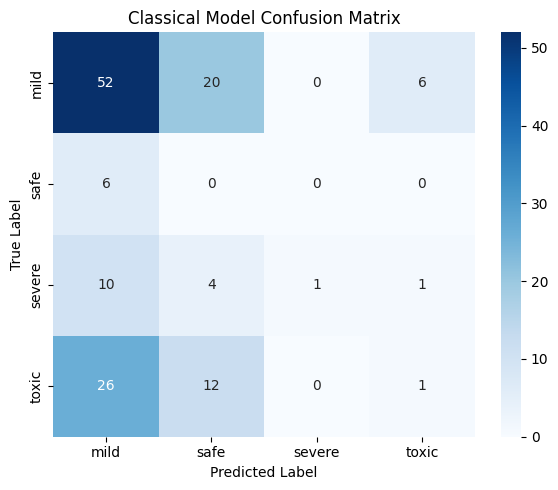

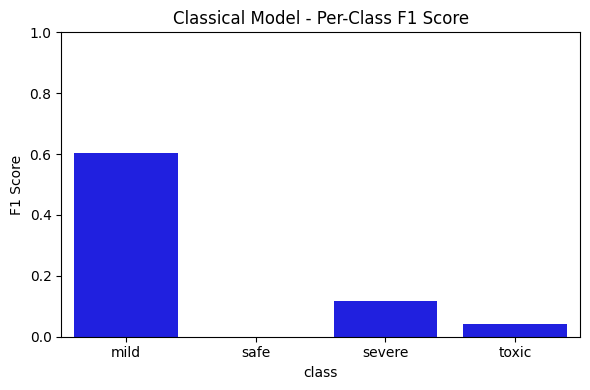

Prediction log saved to ../results/errors/classical/phase1_classical_prediction_log.csv
False Negatives saved to: ../results/errors/classical/phase1_classical_false_negatives.csv
False Positives saved to: ../results/errors/classical/phase1_classical_false_positives.csv
Error summary saved to ../results/errors/classical/phase1_classical_error_summary.json


In [3]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from scipy.sparse import hstack
import json

# =============================
# Load Data
# =============================
df = pd.read_csv("../data/test/error_analysis_dataset.csv")
X = df['cleaned_comment']
y = df['expected_label']

# =============================
# Load Model and Vectorizer
# =============================
le = joblib.load("../models/saved/classical/label_encoder.pkl")
y_enc = le.transform(y)
vectorizer = joblib.load("../models/saved/classical/vectorizer.pkl")
model = joblib.load("../models/saved/classical/xgboost.pkl")

X_vec = vectorizer.transform(X)

# =============================
# Generate Numeric Features
# =============================
def count_features(text):
    return pd.Series({
        "char_count": len(text),
        "word_count": len(text.split()),
        "num_uppercase": sum(1 for c in text if c.isupper()),
        "num_exclamation": text.count("!"),
        "num_question": text.count("?"),
        "has_swear": int(any(bad in text.lower() for bad in ["fuck", "shit", "idiot", "stupid", "dumb"]))
    })

df_features = df["cleaned_comment"].apply(count_features)
X_num = df_features.values

X_combined = hstack([X_vec, X_num])

# =============================
# Predict
# =============================
y_pred_enc = model.predict(X_combined)
y_pred = le.inverse_transform(y_pred_enc)

# =============================
# Classification Report & Confusion Matrix
# =============================
print(classification_report(y, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Classical Model Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# =============================
# Per-Class F1 Score Visualization
# =============================
report = classification_report(y, y_pred, target_names=le.classes_, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in le.classes_]

df_f1 = pd.DataFrame({"class": le.classes_, "f1_score": f1_scores})
plt.figure(figsize=(6,4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="blue")
plt.title("Classical Model - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# =============================
# Save Prediction Log
# =============================
errors_dir = "../results/errors/classical"
os.makedirs(errors_dir, exist_ok=True)

# Add predictions to dataframe
df["predicted_label"] = y_pred
df["predicted_label_enc"] = y_pred_enc

try:
    y_prob = model.predict_proba(X_combined)
    df[[f"prob_{c}" for c in le.classes_]] = y_prob
except:
    print("XGBoost model does not expose predict_proba() for this configuration.")

pred_log_path = os.path.join(errors_dir, "phase1_classical_prediction_log.csv")
df.to_csv(pred_log_path, index=False)

print(f"Prediction log saved to {pred_log_path}")

# =============================
# Save FP/FN tables
# =============================
false_predictions = df[df["predicted_label"] != df["expected_label"]]

false_negatives = false_predictions.copy()

false_positives = false_predictions.copy()

fn_path = os.path.join(errors_dir, "phase1_classical_false_negatives.csv")
fp_path = os.path.join(errors_dir, "phase1_classical_false_positives.csv")

false_negatives.to_csv(fn_path, index=False)
false_positives.to_csv(fp_path, index=False)

print(f"False Negatives saved to: {fn_path}")
print(f"False Positives saved to: {fp_path}")

# =============================
# Save Error Summary JSON
# =============================
error_summary = {
    "model": "Classical_XGBoost",
    "total_samples": len(df),
    "total_errors": len(false_predictions),
    "false_negative_count": len(false_negatives),
    "false_positive_count": len(false_positives),
    "accuracy": (y_pred == y).mean(),
    "macro_f1": float(np.mean(f1_scores)),
}

summary_path = os.path.join(errors_dir, "phase1_classical_error_summary.json")
with open(summary_path, "w") as f:
    json.dump(error_summary, f, indent=4)

print(f"Error summary saved to {summary_path}")

---
# DistilBERT Error Analysis

This section evaluates DistilBERT model predictions against ground truth labels to identify systematic misclassifications. 

The analysis focuses on error patterns, label-specific performance, and correlations with comment severity and toxicity, providing actionable insights for model refinement and data optimization.

=== DistilBERT Evaluation ===
              precision    recall  f1-score   support

        mild     0.5106    0.3077    0.3840        78
        safe     0.0337    0.5000    0.0632         6
      severe     0.0000    0.0000    0.0000        16
       toxic     0.3333    0.0256    0.0476        39

    accuracy                         0.2014       139
   macro avg     0.2194    0.2083    0.1237       139
weighted avg     0.3815    0.2014    0.2316       139



/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

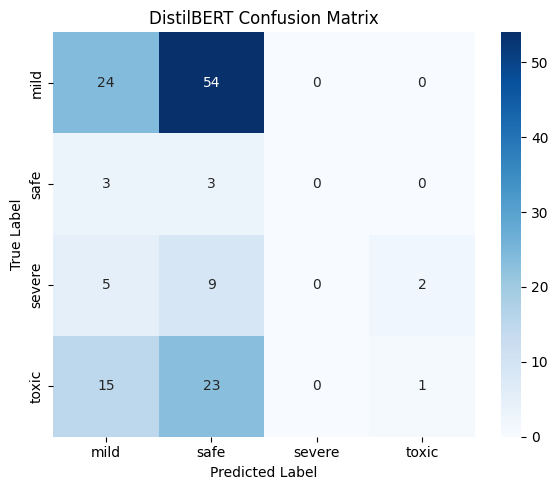

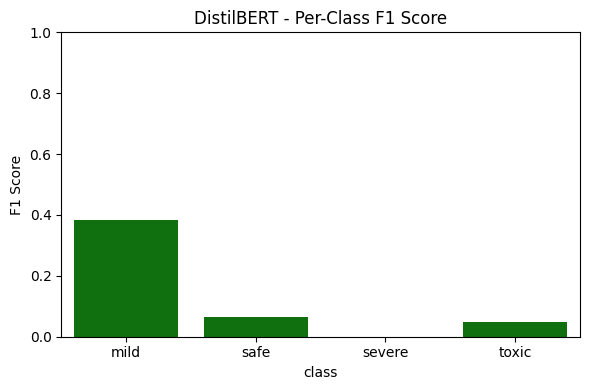

Prediction log saved to ../results/errors/transformer/distilBert/phase2_distilbert_prediction_log.csv
False Negatives saved to: ../results/errors/transformer/distilBert/phase2_distilbert_false_negatives.csv
False Positives saved to: ../results/errors/transformer/distilBert/phase2_distilbert_false_positives.csv
Error summary saved to ../results/errors/transformer/distilBert/phase2_distilbert_error_summary.json


In [4]:
# =============================
# 02. DistilBERT Experiments (Fixed)
# =============================

import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

# =============================
# Paths
# =============================
DATA_PATH = "../data/test/error_analysis_dataset.csv"
MODEL_PATH = "../models/saved/bert"
RESULTS_DIR = "../results/errors/transformer/distilBert"
os.makedirs(RESULTS_DIR, exist_ok=True)

# =============================
# Load Data
# =============================
df = pd.read_csv(DATA_PATH)

if "cleaned_comment" in df.columns and "expected_label" in df.columns:
    X = df["cleaned_comment"].tolist()
    y = df["expected_label"].tolist()
else:
    raise ValueError("CSV must contain 'cleaned_comment' and 'expected_label' columns.")

# =============================
# Load DistilBERT Model
# =============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(MODEL_PATH, "checkpoint-17500"))
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# =============================
# Load Labels
# =============================
id2label = joblib.load(os.path.join(MODEL_PATH, "id2label.pkl"))
label2id = joblib.load(os.path.join(MODEL_PATH, "label2id.pkl"))
class_names = [id2label[i] for i in range(len(id2label))]

# =============================
# Tokenize and Predict
# =============================
batch_size = 16
preds = []
true_labels = []

for i in range(0, len(X), batch_size):
    batch_texts = X[i:i + batch_size]
    batch_labels = y[i:i + batch_size]

    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(batch_labels)

y_pred = [id2label[p] for p in preds]

# =============================
# Classification Report
# =============================
report = classification_report(true_labels, y_pred, target_names=class_names, output_dict=True, digits=4)
print("=== DistilBERT Evaluation ===")
print(classification_report(
    true_labels,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0 
))

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(true_labels, y_pred, labels=class_names)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# =============================
# Per-Class F1 Score Visualization
# =============================
f1_scores = [report[label]['f1-score'] for label in class_names]
df_f1 = pd.DataFrame({"class": class_names, "f1_score": f1_scores})

plt.figure(figsize=(6,4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="green")
plt.title("DistilBERT - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# =============================
# Save Prediction Log
# =============================
df["predicted_label"] = y_pred

pred_log_path = os.path.join(RESULTS_DIR, "phase2_distilbert_prediction_log.csv")
df.to_csv(pred_log_path, index=False)
print(f"Prediction log saved to {pred_log_path}")

# =============================
# Save FP/FN Tables
# =============================
false_predictions = df[df["predicted_label"] != df["expected_label"]]
false_negatives = false_predictions.copy()
false_positives = false_predictions.copy()

fn_path = os.path.join(RESULTS_DIR, "phase2_distilbert_false_negatives.csv")
fp_path = os.path.join(RESULTS_DIR, "phase2_distilbert_false_positives.csv")

false_negatives.to_csv(fn_path, index=False)
false_positives.to_csv(fp_path, index=False)
print(f"False Negatives saved to: {fn_path}")
print(f"False Positives saved to: {fp_path}")

# =============================
# Save Error Summary JSON
# =============================
results = {
    "model": "DistilBERT",
    "total_samples": len(df),
    "total_errors": len(false_predictions),
    "false_negative_count": len(false_negatives),
    "false_positive_count": len(false_positives),
    "accuracy": np.mean(np.array(true_labels) == np.array(y_pred)),
    "macro_f1": float(np.mean(f1_scores)),
    "per_class_f1": {label: float(report[label]['f1-score']) for label in class_names}
}

summary_path = os.path.join(RESULTS_DIR, "phase2_distilbert_error_summary.json")
with open(summary_path, "w") as f:
    json.dump(results, f, indent=4)
print(f"Error summary saved to {summary_path}")

---
# ToxicBERT Error Analysis

This section evaluates ToxicBERT model predictions against ground truth labels to identify systematic misclassifications. 

The analysis focuses on error patterns, label-specific performance, and correlations with comment severity and toxicity, providing actionable insights for model refinement and data optimization.

=== ToxicBERT Evaluation ===
              precision    recall  f1-score   support

        mild     0.5312    0.2179    0.3091        78
        safe     0.0319    0.5000    0.0600         6
      severe     0.0000    0.0000    0.0000        16
       toxic     0.3846    0.1282    0.1923        39

    accuracy                         0.1799       139
   macro avg     0.2369    0.2115    0.1403       139
weighted avg     0.4074    0.1799    0.2300       139



/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

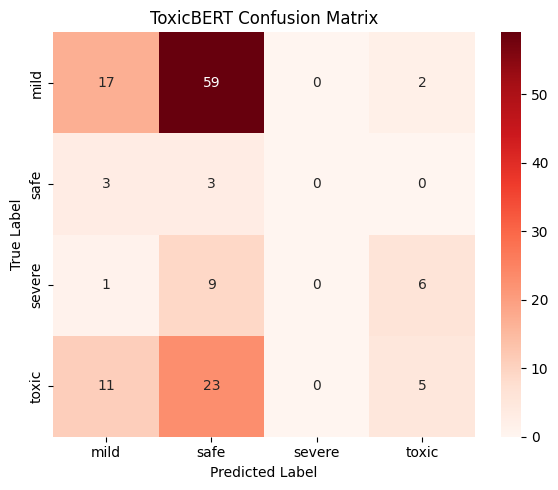

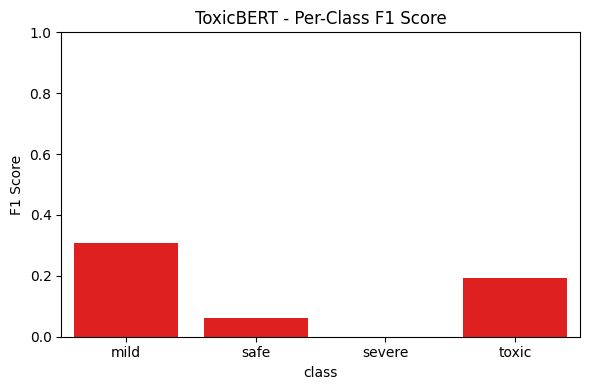

Prediction log saved to ../results/errors/transformer/toxicBert/phase2.5_toxicBERT_prediction_log.csv
False Negatives saved to: ../results/errors/transformer/toxicBert/phase2.5_toxicBERT_false_negatives.csv
False Positives saved to: ../results/errors/transformer/toxicBert/phase2.5_toxicBERT_false_positives.csv
Error summary saved to ../results/errors/transformer/toxicBert/phase2.5_toxicBERT_error_summary.json


In [24]:
# =============================
# 03. ToxicBERT Experiments
# =============================

import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

# =============================
# Paths
# =============================
DATA_PATH = "../data/test/error_analysis_dataset.csv"
MODEL_PATH = "../models/saved/toxic_bert"
RESULTS_DIR = "../results/errors/transformer/toxicBert"
os.makedirs(RESULTS_DIR, exist_ok=True)

# =============================
# Load Data
# =============================
df = pd.read_csv(DATA_PATH)

if "cleaned_comment" in df.columns and "expected_label" in df.columns:
    X = df["cleaned_comment"].tolist()
    y = df["expected_label"].tolist()
else:
    raise ValueError("CSV must contain 'cleaned_comment' and 'expected_label' columns.")

# =============================
# Load ToxicBERT Model
# =============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(MODEL_PATH, "checkpoint-48000"))
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# =============================
# Load Label Mappings
# =============================
id2label = joblib.load(os.path.join(MODEL_PATH, "id2labelToxicBERT.pkl"))
label2id = joblib.load(os.path.join(MODEL_PATH, "label2idToxicBERT.pkl"))
class_names = [id2label[i] for i in range(len(id2label))]

# =============================
# Tokenize and Predict in Batches
# =============================
batch_size = 16
preds = []
true_labels = []

for i in range(0, len(X), batch_size):
    batch_texts = X[i:i + batch_size]
    batch_labels = y[i:i + batch_size]

    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(batch_labels)

y_pred = [id2label[p] for p in preds]

# =============================
# Classification Report
# =============================
report = classification_report(true_labels, y_pred, target_names=class_names, output_dict=True, digits=4)
print("=== ToxicBERT Evaluation ===")
print(classification_report(true_labels, y_pred, target_names=class_names, digits=4, zero_division=0))

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(true_labels, y_pred, labels=class_names)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Reds')
plt.title("ToxicBERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# =============================
# Per-Class F1 Score Visualization
# =============================
f1_scores = [report[label]['f1-score'] for label in class_names]
df_f1 = pd.DataFrame({"class": class_names, "f1_score": f1_scores})

plt.figure(figsize=(6,4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="red")
plt.title("ToxicBERT - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# =============================
# Save Prediction Log
# =============================
df["predicted_label"] = y_pred

pred_log_path = os.path.join(RESULTS_DIR, "phase2.5_toxicBERT_prediction_log.csv")
df.to_csv(pred_log_path, index=False)
print(f"Prediction log saved to {pred_log_path}")

# =============================
# Save FP/FN Tables
# =============================
false_predictions = df[df["predicted_label"] != df["expected_label"]]
false_negatives = false_predictions.copy()
false_positives = false_predictions.copy()

fn_path = os.path.join(RESULTS_DIR, "phase2.5_toxicBERT_false_negatives.csv")
fp_path = os.path.join(RESULTS_DIR, "phase2.5_toxicBERT_false_positives.csv")

false_negatives.to_csv(fn_path, index=False)
false_positives.to_csv(fp_path, index=False)
print(f"False Negatives saved to: {fn_path}")
print(f"False Positives saved to: {fp_path}")

# =============================
# Save Error Summary JSON
# =============================
results = {
    "model": "ToxicBERT",
    "total_samples": len(df),
    "total_errors": len(false_predictions),
    "false_negative_count": len(false_negatives),
    "false_positive_count": len(false_positives),
    "accuracy": np.mean(np.array(true_labels) == np.array(y_pred)),
    "macro_f1": float(np.mean(f1_scores)),
    "per_class_f1": {label: float(report[label]['f1-score']) for label in class_names}
}

summary_path = os.path.join(RESULTS_DIR, "phase2.5_toxicBERT_error_summary.json")
with open(summary_path, "w") as f:
    json.dump(results, f, indent=4)
print(f"Error summary saved to {summary_path}")


---
# LLM Error Analysis

This section evaluates qwen3-4b-thinking-2507 model predictions against ground truth labels to identify systematic misclassifications. 

The analysis focuses on error patterns, label-specific performance, and correlations with comment severity and toxicity, providing actionable insights for model refinement and data optimization.

Found 5 batch files.
Processing error_analysis_dataset_batch_1.csv, 30 comments total.


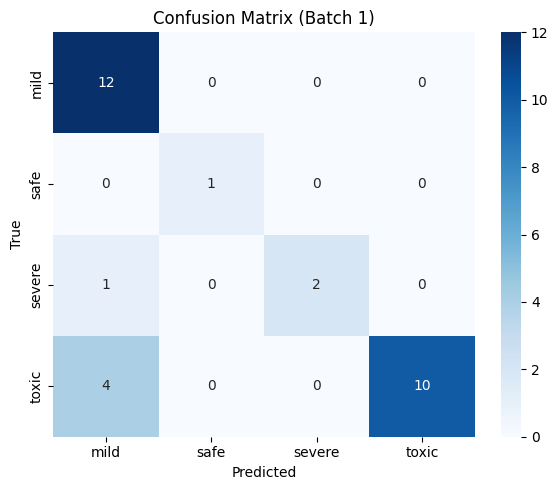

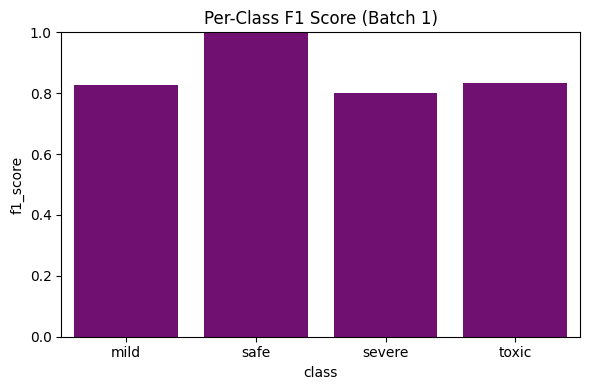

Batch 1 processed: 18/30 correct, 25/30 acceptable
Processing error_analysis_dataset_batch_2.csv, 21 comments total.


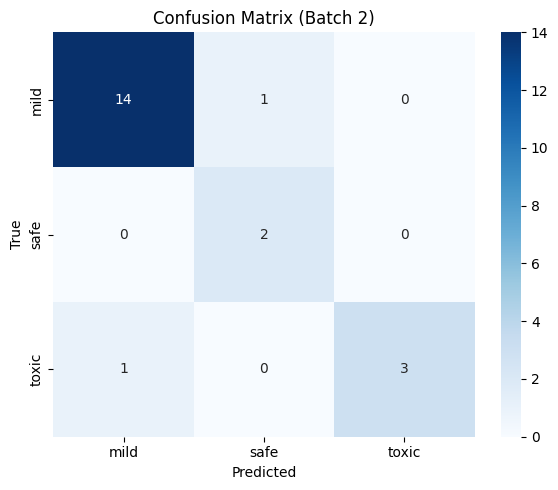

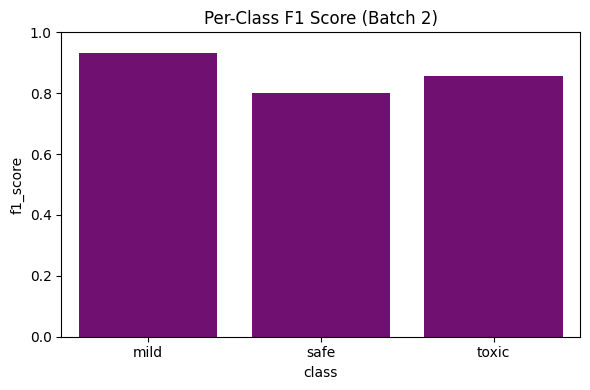

Batch 2 processed: 15/21 correct, 19/21 acceptable
Processing error_analysis_dataset_batch_3.csv, 32 comments total.


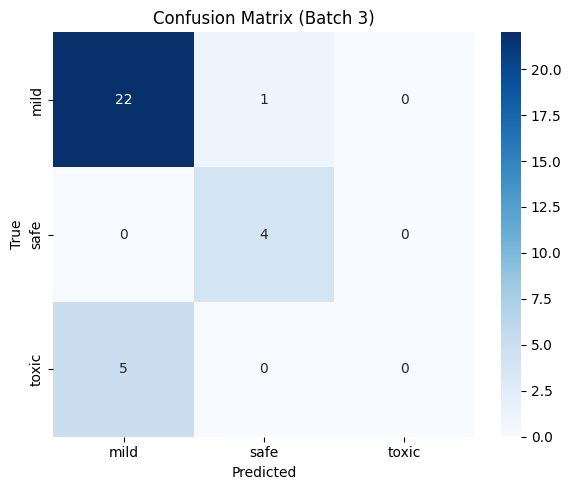

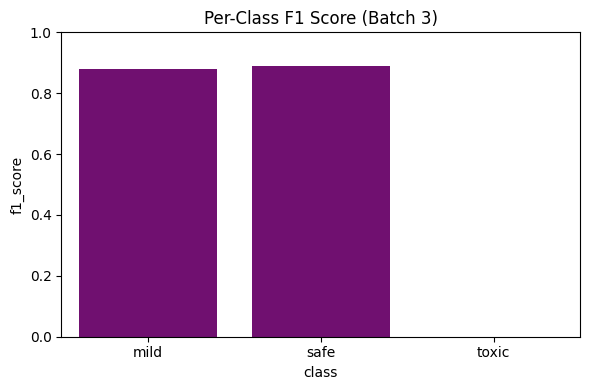

Batch 3 processed: 20/32 correct, 26/32 acceptable
Processing error_analysis_dataset_batch_4.csv, 27 comments total.


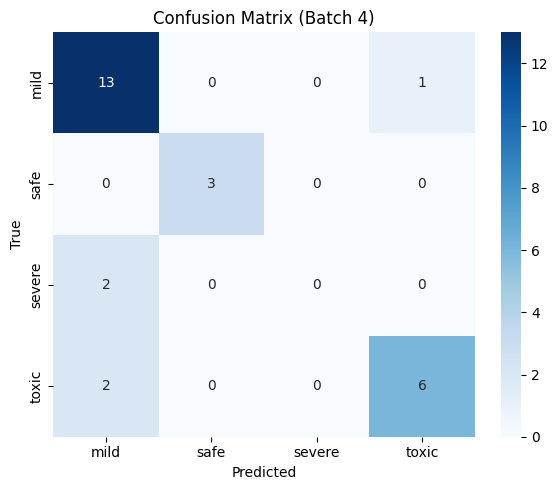

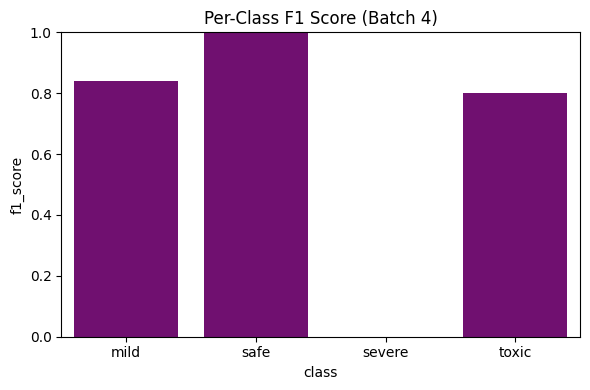

Batch 4 processed: 11/27 correct, 22/27 acceptable
Processing error_analysis_dataset_batch_5.csv, 29 comments total.


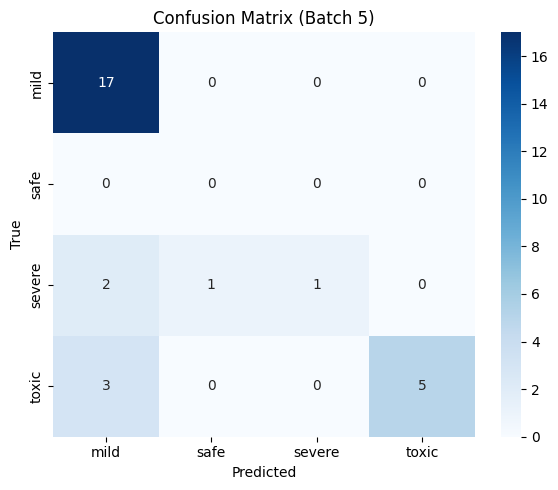

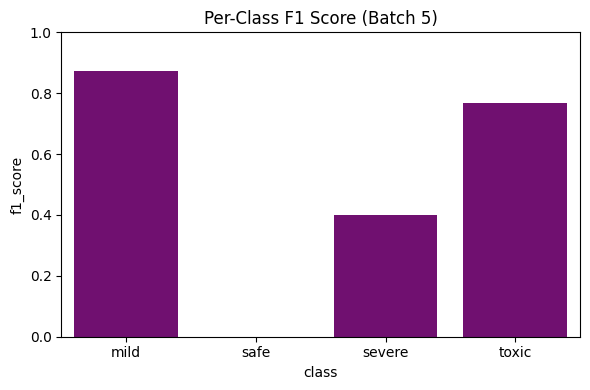

Batch 5 processed: 13/29 correct, 23/29 acceptable


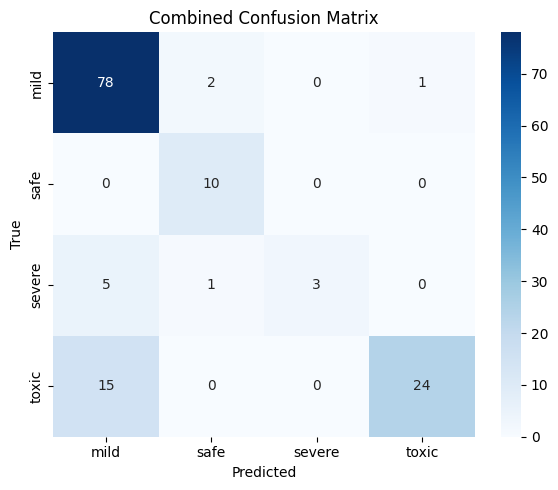

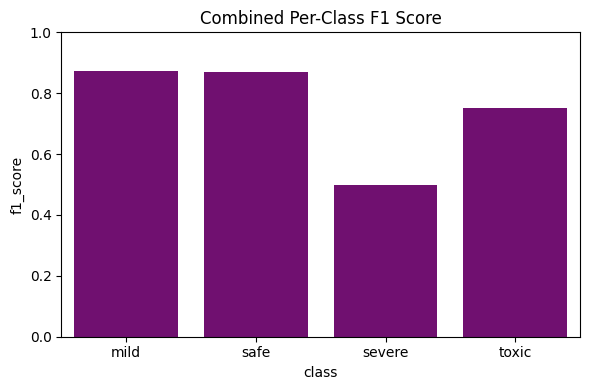


Combined summary saved to: /Users/ivansmiljanic/SyntaxBase/SyntaxBase-moderation-microservice/results/errors/llm/qwen3-4b-thinking/qwen_combined_summary.json


In [ ]:
# =============================
# LLM Moderation Evaluation - Error Analysis
# =============================

import csv
import json
import re
from pathlib import Path
from collections import defaultdict
from typing import Dict, Any
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import requests

# -----------------------------
# Paths
# -----------------------------
repo_root = Path.cwd().parent

DATA_DIR = repo_root / "data" / "test" / "llm" / "error_analysis_batch"
RESULTS_DIR = repo_root / "results" / "errors" / "llm" / "qwen3-4b-thinking"
os.makedirs(RESULTS_DIR, exist_ok=True)

batch_files = sorted(DATA_DIR.glob("error_analysis_dataset_batch_*.csv"))
print(f"Found {len(batch_files)} batch files.")

# -----------------------------
# Inline LLM Client
# -----------------------------
class LLMModerationClient:
    """Query local LLM for moderation."""
    def __init__(
        self,
        base_url: str = "http://localhost:1234/v1/chat/completions",
        model_name: str = "qwen3-4b-thinking-plus",
        prompt_text: str = None
    ):
        self.base_url = base_url
        self.model_name = model_name

        # Default inline system prompt if none provided
        if prompt_text is None:
            self.system_prompt = """
You are a Comment Moderation AI. Classify a single forum comment.

Return **JSON only**. No extra text. No explanations outside JSON.

Labels:
- safe: no offensive content
- mild: minor insults or slightly rude
- toxic: strong insults, harassment
- severe: extreme aggression or identity-based hate

Rules:
- Exactly one label per comment.
- Sarcasm must be taken literally.
- Profanity alone does NOT imply severe; use toxic unless hate-driven.

Output format:
{"label": "<safe|mild|toxic|severe>", "reasoning": "<short explanation>"}
"""
        else:
            self.system_prompt = prompt_text

    def _extract_json(self, text: str):
        match = re.search(r"\{.*\}", text, flags=re.DOTALL)
        if not match:
            raise ValueError(f"No JSON object found in LLM output: {text}")
        return json.loads(match.group(0))

    def classify_comment(self, comment: str) -> Dict[str, Any]:
        payload = {
            "model": self.model_name,
            "messages": [
                {"role": "system", "content": self.system_prompt},
                {"role": "user", "content": comment}
            ],
            "temperature": 0.0,
            "max_tokens": 1024,
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "moderation_response",
                    "schema": {
                        "type": "object",
                        "properties": {
                            "label": {
                                "type": "string",
                                "enum": ["safe", "mild", "toxic", "severe"]
                            },
                            "reasoning": {"type": "string"}
                        },
                        "required": ["label", "reasoning"]
                    }
                }
            }
        }

        try:
            response = requests.post(self.base_url, json=payload, timeout=60)
            response.raise_for_status()
            content = response.json()["choices"][0]["message"]["content"].strip()
            try:
                return json.loads(content)
            except json.JSONDecodeError:
                return self._extract_json(content)
        except Exception as e:
            print(f"LLM API error: {e}\nComment: {comment}")
            # Fallback to 'safe' label if API fails
            return {"label": "safe", "reasoning": f"LLM error: {e}"}

# -----------------------------
# Evaluate batch
# -----------------------------
client = LLMModerationClient()
all_rows = []

def evaluate_batch(batch_path: Path):
    rows_out = []
    y_true_exact = []
    y_true_acceptable = []
    y_pred = []

    with batch_path.open("r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        print(f"Processing {batch_path.name}, {len(list(reader))} comments total.")
        f.seek(0)
        next(reader)  # skip header
        for row in reader:
            # Clean column access
            comment = row.get("cleaned_comment", "").strip()
            expected = row.get("expected_label", "").strip()
            acceptable = [x.strip() for x in row.get("acceptable_labels", "").split(",") if x.strip()]

            if not comment or not expected:
                continue

            result = client.classify_comment(comment)
            predicted = result["label"]

            # Append for metrics
            y_true_exact.append(expected)
            y_true_acceptable.append(predicted if predicted in acceptable else expected)
            y_pred.append(predicted)

            rows_out.append({
                "comment": comment,
                "expected_label": expected,
                "acceptable_labels": row.get("acceptable_labels", ""),
                "predicted": predicted,
                "is_correct": predicted == expected,
                "is_acceptable": predicted in acceptable,
                "reasoning": result.get("reasoning", "")
            })

    # Save CSV
    batch_id = batch_path.stem.split("_")[-1]
    output_csv = RESULTS_DIR / f"qwen_results_batch_{batch_id}.csv"
    if rows_out:
        with output_csv.open("w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=rows_out[0].keys())
            writer.writeheader()
            writer.writerows(rows_out)

    all_rows.extend(rows_out)

    # Metrics
    if not rows_out:
        return []

    labels = sorted(list(set(y_true_exact + y_pred)))
    accuracy = accuracy_score(y_true_acceptable, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_acceptable, y_pred, labels=labels, zero_division=0)
    macro_f1 = f1.mean()

    cm = confusion_matrix(y_true_acceptable, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix (Batch {batch_id})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    df_f1 = pd.DataFrame({"class": labels, "f1_score": f1})
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df_f1, x="class", y="f1_score", color="purple")
    plt.title(f"Per-Class F1 Score (Batch {batch_id})")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

    # Save summary
    output_json = RESULTS_DIR / f"qwen_summary_batch_{batch_id}.json"
    summary = {
        "model": "Qwen3-4B-Thinking",
        "batch": batch_id,
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "per_class_f1": dict(zip(labels, f1)),
        "confusion_matrix": {label: {lbl: int(val) for lbl, val in zip(labels, row)} for label, row in zip(labels, cm)}
    }

    with output_json.open("w", encoding="utf-8") as f:
        json.dump(summary, f, indent=4)

    print(f"Batch {batch_id} processed: {sum(r['is_correct'] for r in rows_out)}/{len(rows_out)} correct, "
          f"{sum(r['is_acceptable'] for r in rows_out)}/{len(rows_out)} acceptable")
    return rows_out

# -----------------------------
# Run all batches
# -----------------------------
for batch_path in batch_files:
    evaluate_batch(batch_path)

# -----------------------------
# Combined Analysis
# -----------------------------
df_all = pd.DataFrame(all_rows)
if not df_all.empty:
    labels = sorted(df_all["expected_label"].unique())
    y_true_acceptable = df_all.apply(lambda r: r["predicted"] if r["is_acceptable"] else r["expected_label"], axis=1)
    y_pred = df_all["predicted"].tolist()

    accuracy = accuracy_score(y_true_acceptable, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_acceptable, y_pred, labels=labels, zero_division=0)
    macro_f1 = f1.mean()
    per_class_f1 = dict(zip(labels, f1))

    cm = confusion_matrix(y_true_acceptable, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Combined Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    df_f1 = pd.DataFrame({"class": labels, "f1_score": f1})
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_f1, x="class", y="f1_score", color="purple")
    plt.title("Combined Per-Class F1 Score")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

    summary_path = RESULTS_DIR / "qwen_combined_summary.json"
    combined_summary = {
        "model": "Qwen3-4B-Thinking",
        "total_samples": len(df_all),
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "per_class_f1": per_class_f1,
        "confusion_matrix": {label: {lbl: int(val) for lbl, val in zip(labels, row)} for label, row in zip(labels, cm)}
    }

    with summary_path.open("w", encoding="utf-8") as f:
        json.dump(combined_summary, f, indent=4)

    print("\nCombined summary saved to:", summary_path)
else:
    print("No rows collected. Check CSV paths and columns.")

---
# Comparison between all models and phases

In [ ]:
import pandas as pd
from pathlib import Path
import json

repo_root = Path.cwd().parent

summary_files = {
    "Classical_XGBoost": repo_root / "results/errors/classical/phase1_classical_error_summary.json",
    "DistilBERT": repo_root / "results/errors/transformer/distilBert/phase2_distilbert_error_summary.json",
    "ToxicBERT": repo_root / "results/errors/transformer/toxicBert/phase2.5_toxicBERT_error_summary.json",
    "Qwen3-4B-Thinking": repo_root / "results/errors/llm/qwen3-4b-thinking/qwen_combined_summary.json"
}

all_rows = []

for model, path in summary_files.items():
    if not path.exists():
        print(f"File not found: {path}")
        continue
    with path.open("r") as f:
        summary = json.load(f)
        summary["model"] = model

        if "per_class_f1" in summary:
            for k, v in summary["per_class_f1"].items():
                summary[f"f1_{k}"] = v
            del summary["per_class_f1"]

        if "confusion_matrix" in summary:
            for true_label, preds in summary["confusion_matrix"].items():
                for pred_label, count in preds.items():
                    summary[f"cm_{true_label}_{pred_label}"] = count
            del summary["confusion_matrix"]

        all_rows.append(summary)

df_summary = pd.DataFrame(all_rows)

# Reorder columns nicely
cols_order = ["model", "total_samples", "total_errors", "false_negative_count", 
              "false_positive_count", "accuracy", "macro_f1"] + \
             [c for c in df_summary.columns if c.startswith("f1_")] + \
             [c for c in df_summary.columns if c.startswith("cm_")]

df_summary = df_summary.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)
df_summary.index += 1

df_summary



,model,total_samples,total_errors,false_negative_count,false_positive_count,accuracy,macro_f1,f1_mild,f1_safe,f1_severe,...,cm_safe_severe,cm_safe_toxic,cm_severe_mild,cm_severe_safe,cm_severe_severe,cm_severe_toxic,cm_toxic_mild,cm_toxic_safe,cm_toxic_severe,cm_toxic_toxic
1,Qwen3-4B-Thinking,139,NaN,NaN,NaN,0.827338,0.747768,0.871508,0.869565,0.5,...,0.0,0.0,5.0,1.0,3.0,0.0,15.0,0.0,0.0,24.0
2,Classical_XGBoost,139,85.0,85.0,85.0,0.388489,0.191213,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ToxicBERT,139,114.0,114.0,114.0,0.179856,0.140350,0.309091,0.060000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DistilBERT,139,111.0,111.0,111.0,0.201439,0.123694,0.384000,0.063158,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


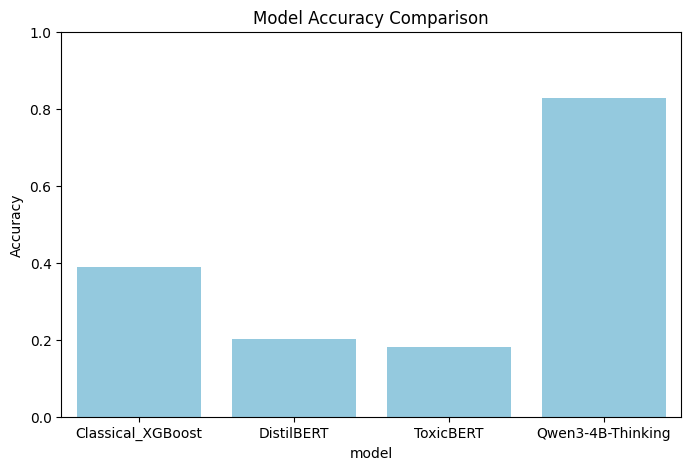

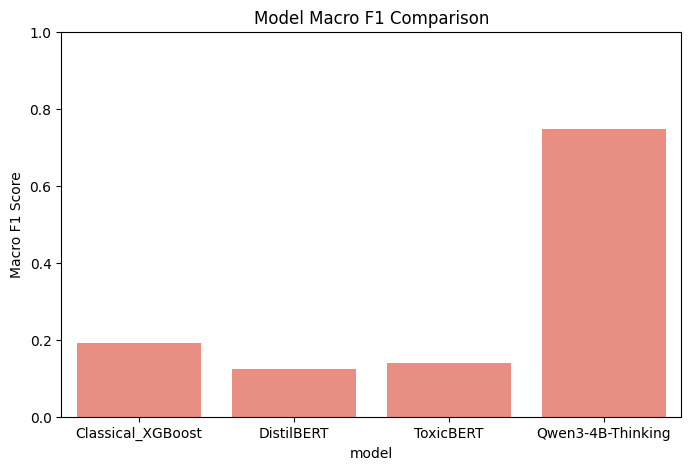

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=df_summary, x="model", y="accuracy", color="skyblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=df_summary, x="model", y="macro_f1", color="salmon")
plt.title("Model Macro F1 Comparison")
plt.ylabel("Macro F1 Score")
plt.ylim(0,1)
plt.show()

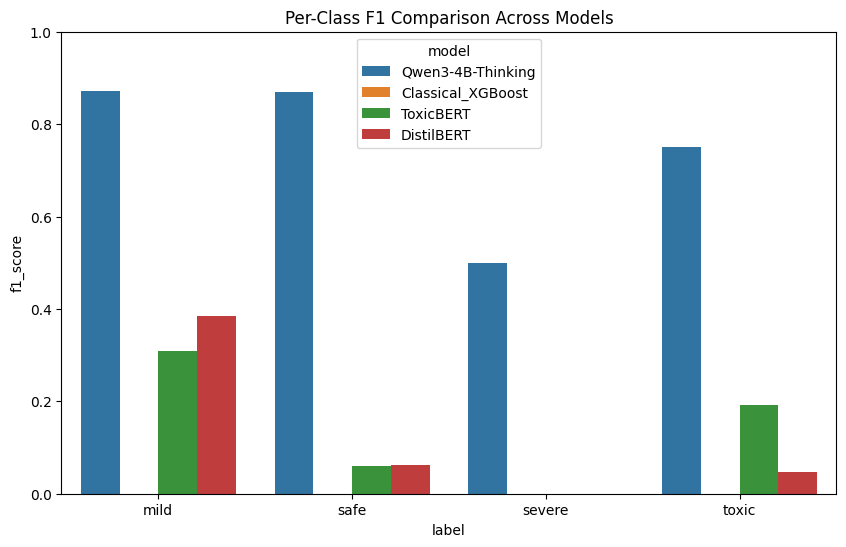

In [41]:
per_class_rows = []
for _, row in df_summary.iterrows():
    for col in df_summary.columns:
        if col.startswith("f1_"):
            label = col.replace("f1_", "")
            per_class_rows.append({
                "model": row["model"],
                "label": label,
                "f1_score": row[col]
            })

df_per_class = pd.DataFrame(per_class_rows)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df_per_class, x="label", y="f1_score", hue="model")
plt.title("Per-Class F1 Comparison Across Models")
plt.ylim(0,1)
plt.show()

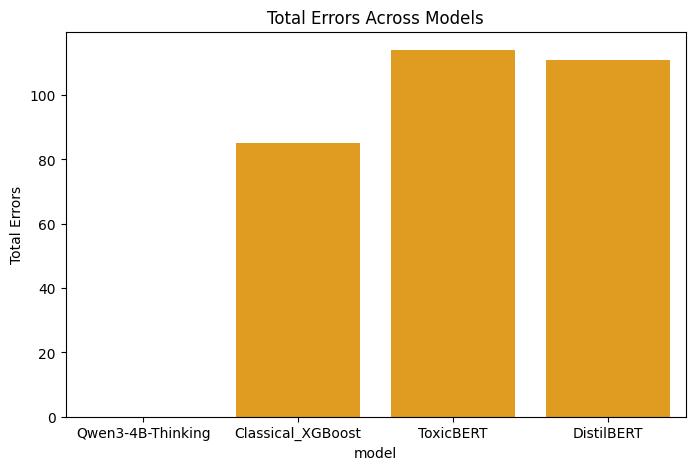

In [42]:
plt.figure(figsize=(8,5))
df_summary["total_errors"] = df_summary.get("total_errors", pd.Series([0]*len(df_summary)))
sns.barplot(data=df_summary, x="model", y="total_errors", color="orange")
plt.title("Total Errors Across Models")
plt.ylabel("Total Errors")
plt.show()
